In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import linregress, t
import umap
import networkx as nx

# Debugging

In [14]:
import pandas as pd

# ----------------------------
# Load data
# ----------------------------
sol_lpa_matched = pd.read_csv("/proj/epi/CVDGeneNas/migraff/SOL/pheno/lpa/solLpa_idmatched.csv")
sol_gengrp6 = pd.read_csv("/proj/epi/CVDGeneNas/migraff/SOL/pheno/lpa/SOL_gengrp6.csv")
sol_nwd_crosswalk = pd.read_csv("/nas/longleaf/home/catererz/epi/GRiD/files/SOL_NWD_IDs_crosswalk.csv")
frozen_nwd_crosswalk = pd.read_csv("/proj/epi/Genetic_Data_Center/SOL/sequenced/hchs_genomics_id_mapping_240715.txt", sep="\t")

# normalize column names
sol_lpa_matched.columns = sol_lpa_matched.columns.str.lower()
sol_gengrp6.columns = sol_gengrp6.columns.str.lower()
sol_nwd_crosswalk.columns = sol_nwd_crosswalk.columns.str.lower()
frozen_nwd_crosswalk.columns = frozen_nwd_crosswalk.columns.str.lower()

print("Initial shapes:")
print("SOL LPA matched:", sol_lpa_matched.shape, "Columns:", sol_lpa_matched.columns.tolist())
print("SOL Gengrp6:", sol_gengrp6.shape, "Columns:", sol_gengrp6.columns.tolist())
print("SOL NWD crosswalk:", sol_nwd_crosswalk.shape, "Columns:", sol_nwd_crosswalk.columns.tolist())
print("Frozen NWD crosswalk:", frozen_nwd_crosswalk.shape, "Columns:", frozen_nwd_crosswalk.columns.tolist())
print("\nHeads of data:\n", frozen_nwd_crosswalk.head())

print('\nNumber of missing nwd_ids in frozen crosswalk:', frozen_nwd_crosswalk['nwd_id'].isnull().sum())

# ----------------------------
# Load KIV-2 CN estimates
# ----------------------------
kiv_2_cn = pd.read_csv(
    "/nas/longleaf/home/catererz/work/updated_LPA_VNTR_SOFTWARE/lpa_kiv2_cn.txt",
    sep="\t"
)[['ID', 'estimate']]

kiv_2_cn.columns = ['nwd_id', 'estimate']

print("\n")
print("KIV-2 CN shape:", kiv_2_cn.shape)
print("Unique CN NWD_IDs:", kiv_2_cn['nwd_id'].nunique())

# ----------------------------
# Merge data
# ----------------------------

# merge frozen crosswalk with sol_lpa_matched to on the 'id' column
merged_data = pd.merge(
    frozen_nwd_crosswalk[['id', 'nwd_id']],
    sol_lpa_matched,
    on='id',
    how='inner'
)
print("After merging frozen crosswalk with SOL LPA matched:", merged_data.shape, "Columns:", merged_data.columns.tolist())
print(merged_data.head())
print("\nUnique NWD_IDs_X after first merge:", merged_data['nwd_id_x'].nunique(), " Number of missing NWD_IDs_Y:", merged_data['nwd_id_y'].isnull().sum())

# verify that nwd_id_x and nwd_id_y are the same
merged_data = merged_data[merged_data['nwd_id_x'] == merged_data['nwd_id_y']]
merged_data = merged_data.drop(columns=['nwd_id_y'])
merged_data = merged_data.rename(columns={'nwd_id_x': 'nwd_id'})
print("After filtering for matching NWD_IDs:", merged_data.shape, "Columns:", merged_data.columns.tolist())
print("\nUnique NWD_IDs after filtering:", merged_data['nwd_id'].nunique())

# ----------------------------
# Merge with KIV-2 CN estimates
# ----------------------------
final_data_outer = pd.merge(
    merged_data,
    kiv_2_cn,
    on='nwd_id',
    how='outer'
)

print("After merging with KIV-2 CN estimates:", final_data_outer.shape, "Columns:", final_data_outer.columns.tolist())
print("\nUnique NWD_IDs after final merge:", final_data_outer['nwd_id'].nunique())
print("Number of missing estimates:", final_data_outer['estimate'].isnull().sum())

final_data_inner = pd.merge(
    merged_data,
    kiv_2_cn,
    on='nwd_id',
    how='inner'
)
print("After inner merging with KIV-2 CN estimates:", final_data_inner.shape, "Columns:", final_data_inner.columns.tolist())
print("\nUnique NWD_IDs after final inner merge:", final_data_inner['nwd_id'].nunique())
print("Number of missing estimates in inner merge:", final_data_inner['estimate'].isnull().sum())

Initial shapes:
SOL LPA matched: (16415, 6) Columns: ['id', 'subject_id', 'nwd_id', 'gwas_id', 'bkgrd1', 'lpa_nmol']
SOL Gengrp6: (12359, 7) Columns: ['id', 'nwd_id', 'gengrp6', 'gwas_id', 'subject_id', 'bkgrd1', 'sex']
SOL NWD crosswalk: (16415, 22) Columns: ['id', 'strat', 'psu_id', 'gold_id', 'gwas_id', 'subject_id', 'hh_id', 'source', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'goldid', 'sampleid', 'nwd_id']
Frozen NWD crosswalk: (16515, 4) Columns: ['id', 'subject_id', 'nwd_id', 'gwas_id']

Heads of data:
       id subject_id     nwd_id   gwas_id
0   5678  SoL694820        NaN  G0114250
1   6570  SoL714793  NWD725683  G0111052
2  11150  SoL218026  NWD565678  G0114527
3  11243  SoL230755  NWD863074  G0021876
4  19626  SoL760414  NWD161576  G0113603

Number of missing nwd_ids in frozen crosswalk: 2654


KIV-2 CN shape: (7041, 2)
Unique CN NWD_IDs: 7041
After merging frozen crosswalk with SOL LPA matched: (16415, 7) Columns: ['id', 'nwd_id_x', 'sub

In [10]:
# try to map all NWD_IDs to either SOL_ID or GWAS_ID
sol_lpa_matched = pd.read_csv("/proj/epi/CVDGeneNas/migraff/SOL/pheno/lpa/solLpa_idmatched.csv")
sol_gengrp6 = pd.read_csv("/proj/epi/CVDGeneNas/migraff/SOL/pheno/lpa/SOL_gengrp6.csv")
sol_nwd_crosswalk = pd.read_csv("/nas/longleaf/home/catererz/epi/GRiD/files/SOL_NWD_IDs_crosswalk.csv")

sol_lpa_matched.columns = sol_lpa_matched.columns.str.lower()
sol_gengrp6.columns = sol_gengrp6.columns.str.lower()
sol_nwd_crosswalk.columns = sol_nwd_crosswalk.columns.str.lower()

print("Initial shapes:")
print("SOL LPA matched:", sol_lpa_matched.shape)
print("SOL LPA matched head:\n", sol_lpa_matched.head())

print("\nSOL Gengrp6:", sol_gengrp6.shape)
print("SOL Gengrp6 head:\n", sol_gengrp6.head())

print("\nSOL NWD crosswalk:", sol_nwd_crosswalk.shape)
print("SOL NWD crosswalk head:\n", sol_nwd_crosswalk.head())

# iterate through each of the rows of sol_lpa_matched
mapped_nwd_list = []

for index, row in sol_lpa_matched.iterrows():
    nwd_id = None
    if pd.notna(row['nwd_id']):
        nwd_id = row['nwd_id']
    elif pd.notna(row['subject_id']):
        sol_id = row['subject_id']
        nwd_row = sol_nwd_crosswalk[sol_nwd_crosswalk['subject_id'] == sol_id]
        if not nwd_row.empty:
            nwd_id = nwd_row.iloc[0]['nwd_id']
    elif pd.notna(row['gwas_id']):
        gwas_id = row['gwas_id']
        sol_row = sol_gengrp6[sol_gengrp6['gwas_id'] == gwas_id]
        if not sol_row.empty:
            sol_id = sol_row.iloc[0]['subject_id']
            nwd_row = sol_nwd_crosswalk[sol_nwd_crosswalk['subject_id'] == sol_id]
            if not nwd_row.empty:
                nwd_id = nwd_row.iloc[0]['nwd_id']
    
    mapped_nwd_list.append({'nwd_id': nwd_id, 'lpa_nmol': row['lpa_nmol']})

# convert list of dicts to DataFrame at the end
mapped_nwd_ids = pd.DataFrame(mapped_nwd_list)

print("\nMapped NWD IDs shape:", mapped_nwd_ids.shape)
print("Mapped NWD IDs head:\n", mapped_nwd_ids.head())

# count number of non-null NWD_IDs
non_null_nwd_count = mapped_nwd_ids['nwd_id'].notna().sum()
print("Number of non-null NWD_IDs:", non_null_nwd_count)

KIV_2_CN = pd.read_csv("/nas/longleaf/home/catererz/work/updated_LPA_VNTR_SOFTWARE/lpa_kiv2_cn.txt", sep='\t')[['ID',"estimate"]]

# rename ID column to NWD_ID
KIV_2_CN.rename(columns={'ID': 'NWD_ID'}, inplace=True)
KIV_2_CN.columns = [c.lower() for c in KIV_2_CN.columns]

# now lets map the KIV-2 CN estimates to the mapped_nwd_ids dataframe
final_merged = pd.merge(mapped_nwd_ids, KIV_2_CN[['nwd_id','estimate']], on='nwd_id', how='inner')
print("\nFinal merged shape:", final_merged.shape)
print("Final merged head:\n", final_merged.head())

overlap = set(mapped_nwd_ids['nwd_id'].dropna()) & set(KIV_2_CN['nwd_id'])
print("Overlap count:", len(overlap))


# get a list of the file names for the cram files in the directory $CRAM
cram_dir="/proj/epi/Genetic_Data_Center/SOL/cram"

import os

cram_files = [f for f in os.listdir(cram_dir) if f.endswith('.cram')]
cram_file_nwd_ids = [f.split('.')[0] for f in cram_files]

print("Number of CRAM files:", len(cram_files))
print("First 5 CRAM files:", cram_files[:5])

print("Number of unique NWD IDs from CRAM files:", len(set(cram_file_nwd_ids)))

# determine the overlap between these cram file nwd_ids and the non_null nwd_ids from mapped_nwd_ids
cram_overlap = set(cram_file_nwd_ids) & set(mapped_nwd_ids['nwd_id'].dropna())
print("Overlap between CRAM files and mapped NWD IDs:", len(cram_overlap))

# terra submitted aligned reads tsv
sar = pd.read_csv("/nas/longleaf/home/catererz/epi/GRiD/files/submitted_aligned_reads.tsv", sep='\t')

print("Submitted aligned reads shape:", sar.shape)
print("Submitted aligned reads head:\n", sar.head())

# create a new column for the NWD_ID extracted from the "pfb:file_name" column
sar['nwd_id'] = sar['pfb:file_name'].apply(lambda x: os.path.basename(x).split('.')[0])

# print unique nwd_ids in sar
print("Number of unique NWD IDs in SAR:", sar['nwd_id'].nunique())

# now lets see the overlap between the sar nwd_ids and the non_null nwd_ids from mapped_nwd_ids
sar_overlap = set(sar['nwd_id']) & set(mapped_nwd_ids['nwd_id'].dropna())
print("Overlap between SAR NWD IDs and mapped NWD IDs:", len(sar_overlap))

Initial shapes:
SOL LPA matched: (16415, 6)
SOL LPA matched head:
       id subject_id     nwd_id   gwas_id bkgrd1  lpa_nmol
0   5678  SoL694820        NaN  G0114250      3       7.6
1   6570  SoL714793  NWD725683  G0111052      3      10.1
2  11150  SoL218026  NWD565678  G0114527      1     197.3
3  11243  SoL230755  NWD863074  G0021876      3      33.5
4  19626  SoL760414  NWD161576  G0113603    NaN      15.1

SOL Gengrp6: (12359, 7)
SOL Gengrp6 head:
       id     nwd_id          gengrp6   gwas_id subject_id bkgrd1  sex
0   6570  NWD725683          Mexican  G0111052  SoL714793      3    2
1  11150  NWD565678  CentralAmerican  G0114527  SoL218026      1    2
2  11243  NWD863074          Mexican  G0021876  SoL230755      3    1
3  26693  NWD573378        Dominican  G0113113  SoL761543      0    2
4  26874  NWD678576  CentralAmerican  G0065195  SoL673649      1    1

SOL NWD crosswalk: (16415, 22)
SOL NWD crosswalk head:
       id  strat  psu_id gold_id   gwas_id subject_id     hh_id  

# plot generation

All groups: R^2 = 0.2531, p = 2.932e-235
Central American: R^2 = 0.1258, p = 0.0004511
Cuban: R^2 = 0.2419, p = 8.319e-79
Dominican: R^2 = 0.2923, p = 2.209e-50
Mexican: R^2 = 0.1332, p = 2.788e-10
Puerto Rican: R^2 = 0.2555, p = 8.741e-87
South American: R^2 = 0.1796, p = 0.001406
Overall: R² = 0.253, p = 2.9e-235


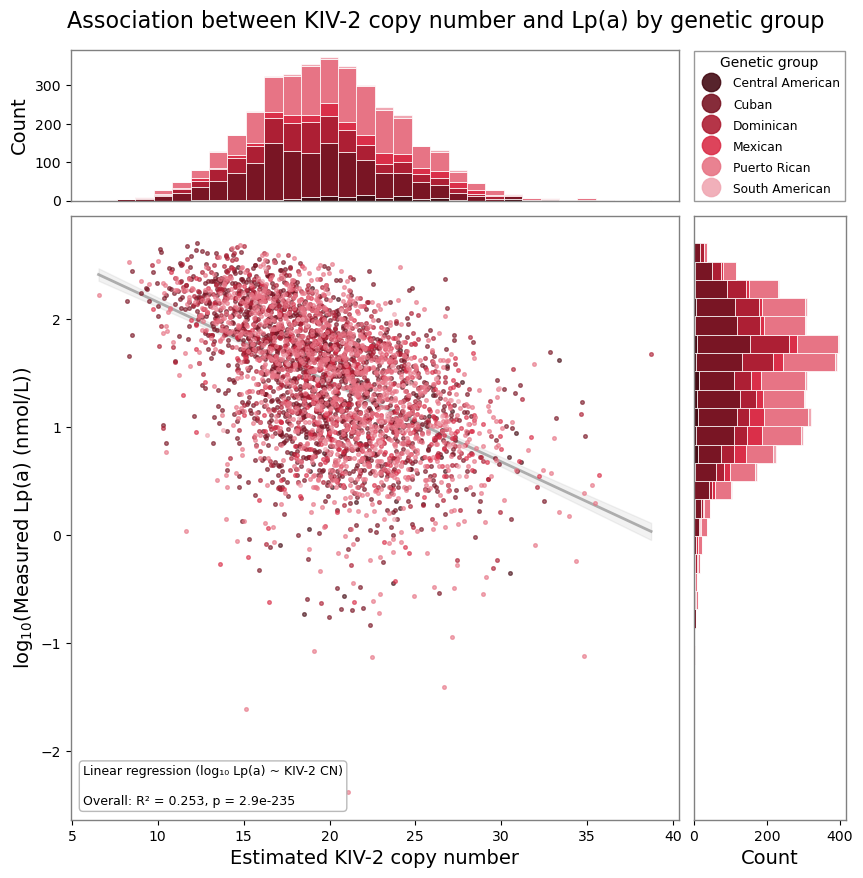

In [25]:
KIV_2_CN = pd.read_csv("/nas/longleaf/home/catererz/work/updated_LPA_VNTR_SOFTWARE/lpa_kiv2_cn.txt", sep='\t')[['ID',"estimate"]]

# rename ID column to NWD_ID
KIV_2_CN.rename(columns={'ID': 'NWD_ID'}, inplace=True)
KIV_2_CN.columns = [c.lower() for c in KIV_2_CN.columns]

MEASURED_LPA = pd.read_csv("/nas/longleaf/home/catererz/epi/GRiD/files/merged_diploid_calls.csv")[["NWD_ID","bkgrd1","lpa_nmol"]]
MEASURED_LPA.columns = [c.lower() for c in MEASURED_LPA.columns]

# clean nwd_id columns
KIV_2_CN['nwd_id'] = KIV_2_CN['nwd_id'].str.strip()
MEASURED_LPA['nwd_id'] = MEASURED_LPA['nwd_id'].str.strip()

# inner join between nwd_id
merged = pd.merge(KIV_2_CN, MEASURED_LPA, on='nwd_id', how='inner')

self_reported_bgk = {
    0: "Dominican",
    1: "Central American",
    2: "Cuban",
    3: "Mexican",
    4: "Puerto Rican",
    5: "South American",
    6: "More than one heritage",
    7: "Other",
    "q": "DK/Refused"
}

# match self reported bgk with column of bkgrd1
merged['bkgrd1'] = pd.to_numeric(merged['bkgrd1'], errors='coerce')
merged['self_reported_bgk'] = merged['bkgrd1'].map(self_reported_bgk).fillna("missing")

# print(merged.head())
# print(merged.shape)

# print("Overlap:", len(set(KIV_2_CN['nwd_id']) & set(MEASURED_LPA['nwd_id'])))

# # count number of missing nwd_id in each dataframe
# print("KIV-2 missing NWD_ID:", KIV_2_CN['nwd_id'].isna().sum())
# print("Measured Lp(a) missing NWD_ID:", MEASURED_LPA['nwd_id'].isna().sum())

# print('\n\n Loading ancestry data...\n')

ancestry_data = pd.read_csv("/proj/epi/CVDGeneNas/migraff/SOL/pheno/lpa/SOL_gengrp6.csv")

ancestry_data.columns = [c.lower() for c in ancestry_data.columns]

ancestry_data['nwd_id'] = ancestry_data['nwd_id'].str.strip()

final_merged = pd.merge(merged, ancestry_data[['nwd_id','gengrp6']], on='nwd_id', how='inner')

# print(final_merged.head())
# print(final_merged.shape)
# print("Final Overlap:", len(set(final_merged['nwd_id'])))

# make me a cross table between self_reported_bgk and gengrp6
cross_tab = pd.crosstab(final_merged['self_reported_bgk'], final_merged['gengrp6'])
# print(cross_tab)


# assume your dataframe is called `merged`
df = final_merged.copy()

# drop missing values just in case
df = df.dropna(subset=["estimate", "lpa_nmol", "gengrp6"])
df = df[df["lpa_nmol"] > 0]
df["log_lpa"] = np.log10(df["lpa_nmol"])

map_gen_groups = {
    'CentralAmerican': 'Central American', 
    'Cuban': 'Cuban', 
    'Dominican': 'Dominican', 
    'Mexican': 'Mexican', 
    'PuertoRican': 'Puerto Rican', 
    'SouthAmerican': 'South American'
}

effect_colors = { 
    'Central American': "#450C15",
    'Cuban': "#791524",
    'Dominican': "#AD1F34",
    'Mexican':  "#DA2F49", 
    'Puerto Rican': "#E77485", 
    'South American': "#F0A8B3"
    }    

df["gengrp6"] = df["gengrp6"].map(map_gen_groups)
groups = sorted(df["gengrp6"].unique())

# Entire dataset 
slope, intercept, r_value, p_value, std_err = linregress(df["estimate"], df["log_lpa"]) 
print(f"All groups: R^2 = {r_value**2:.4f}, p = {p_value:.4g}") 

# By genetic group for 
for g in groups: 
    sub = df[df["gengrp6"] == g] 
    if len(sub) > 1: 
        # Need at least 2 points for correlation 
        slope, intercept, r_value, p_value, std_err = linregress(sub["estimate"], sub["log_lpa"]) 
        print(f"{g}: R^2 = {r_value**2:.4f}, p = {p_value:.4g}") 
    else: 
        print(f"{g}: Not enough data for regression")

# ---- figure layout ----
fig = plt.figure(figsize=(10, 10))
plt.rcParams['axes.grid'] = False


# grid: 4 rows x 4 cols
gs = fig.add_gridspec(
    4, 4,
    width_ratios=[4, 0.05, 0.05, 1],
    height_ratios=[1, 0.05, 0.05, 4],
    hspace=0,
    wspace=0
)

ax_histx = fig.add_subplot(gs[0, 0])
ax_scatter = fig.add_subplot(gs[3, 0])
ax_histy = fig.add_subplot(gs[3, 3])

# ---- scatter plot ----
for g in groups:
    sub = df[df["gengrp6"] == g]
    ax_scatter.scatter(sub["estimate"], sub["log_lpa"], alpha=0.6, label=g, s=7, zorder=3, color=effect_colors[g])

ax_scatter.set_xlabel("Estimated KIV-2 copy number", fontsize=14)
ax_scatter.set_ylabel(r"log$_{10}$(Measured Lp(a) (nmol/L))", fontsize=14)
leg = ax_scatter.legend(
    title="Genetic group", 
    bbox_to_anchor=(1.015, 1.015), 
    loc="lower left",    
    markerscale=5,
    ncol=1,
    fontsize=8.8,
    handleheight=1.5,
    frameon=True,
    fancybox=False
)

for handle in leg.legend_handles:
    if hasattr(handle, "set_alpha"):
        handle.set_alpha(0.9) 

leg.get_frame().set_edgecolor("0.5")
leg.get_frame().set_linewidth(1.0)

# ---- scatter plot + regression lines + confidence bands ----
r2_text = []

# for g in groups:
#     sub = df[df["gengrp6"] == g]

#     ax_scatter.scatter(
#         sub["estimate"], sub["log_lpa"],
#         alpha=0.6, s=7, label=g, zorder=3, color=effect_colors[g]
#     )

    # if len(sub) > 2:
    #     x = sub["estimate"].values
    #     y = sub["log_lpa"].values

    #     slope, intercept, r_value, p_value, std_err = linregress(x, y)
    #     r2 = r_value**2

    #     # regression line
    #     xvals = np.linspace(x.min(), x.max(), 200)
    #     yhat = intercept + slope * xvals

    #     # confidence band
    #     n = len(x)
    #     y_pred = intercept + slope * x
    #     residuals = y - y_pred
    #     s_err = np.sqrt(np.sum(residuals**2) / (n - 2))

    #     t_val = t.ppf(0.975, n - 2)
    #     x_mean = np.mean(x)
    #     conf = t_val * s_err * np.sqrt(
    #         1/n + (xvals - x_mean)**2 / np.sum((x - x_mean)**2)
    #     )

    #     lower = yhat - conf
    #     upper = yhat + conf

    #     # plot regression + CI
    #     line, = ax_scatter.plot(xvals, yhat, linewidth=2, alpha=0.8, zorder=4)
    #     ax_scatter.fill_between(xvals, lower, upper, alpha=0.15, zorder=2)

    #     # store R² text
    #     r2_text.append(f"{g}: R² = {r2:.3f}, p = {p_value:.1e}")

# Include overall regression
slope, intercept, r_value, p_value, std_err = linregress(df["estimate"], df["log_lpa"])
r2 = r_value**2 
print(f"Overall: R² = {r2:.3f}, p = {p_value:.1e}")

# plot overall regression line
xvals = np.linspace(df["estimate"].min(), df["estimate"].max(), 200)
yhat = intercept + slope * xvals
ax_scatter.plot(xvals, yhat, color='gray', linewidth=2, alpha=0.6, zorder=1)

# include confidence band for overall regression
n = len(df)
y = df["log_lpa"].values
y_pred = intercept + slope * df["estimate"].values
residuals = y - y_pred
s_err = np.sqrt(np.sum(residuals**2) / (n - 2))
t_val = t.ppf(0.975, n - 2)
x_mean = np.mean(df["estimate"].values)
conf = t_val * s_err * np.sqrt(
    1/n + (xvals - x_mean)**2 / np.sum((df["estimate"].values - x_mean)**2)
)
lower = yhat - conf
upper = yhat + conf
ax_scatter.fill_between(xvals, lower, upper, color='gray', alpha=0.1, zorder=0)

r2_text.append(f"Overall: R² = {r2:.3f}, p = {p_value:.1e}")

# ---- top histogram (estimate) ----
# for g in groups:
#     sub = df[df["gengrp6"] == g]
#     ax_histx.hist(sub["estimate"], bins=30, alpha=0.6)
data_x = [df[df["gengrp6"] == g]["estimate"] for g in groups]

ax_histx.hist(
    data_x,
    bins=30,
    stacked=True,
    label=groups,
    linewidth=0.5,
    rwidth=1,
    edgecolor='white',
    color=[effect_colors[g] for g in groups]
)

ax_histx.set_ylabel("Count", fontsize=14)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.set_xticks([])

# ---- right histogram (lpa_nmol) ----
# for g in groups:
#     sub = df[df["gengrp6"] == g]
#     ax_histy.hist(sub["log_lpa"], bins=30, orientation="horizontal", alpha=0.6)
data_y = [df[df["gengrp6"] == g]["log_lpa"] for g in groups]

ax_histy.hist(
    data_y,
    bins=30,
    stacked=True,
    orientation="horizontal",
    label=groups, 
    linewidth=0.5,
    rwidth=1,
    edgecolor='white',
    color=[effect_colors[g] for g in groups]
)
# remove y axis ticks
ax_histy.set_yticks([])

ax_histy.set_xlabel("Count", fontsize=14)
ax_histy.tick_params(axis="y", labelleft=False)

# ---- tidy up ----
ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

def style_spines(ax, color="0.5", lw=1.0):
    for spine in ax.spines.values():
        spine.set_color(color)
        spine.set_linewidth(lw)
style_spines(ax_scatter)
style_spines(ax_histx)
style_spines(ax_histy)

# ---- R² explanation text box ----
stats_text = "Linear regression (log₁₀ Lp(a) ~ KIV-2 CN)\n\n" + "\n".join(r2_text)

ax_scatter.text(
    0.02, 0.02,
    stats_text,
    transform=ax_scatter.transAxes,
    fontsize=9,
    verticalalignment="bottom",
    bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.7", alpha=0.9)
)


fig.suptitle("Association between KIV-2 copy number and Lp(a) by genetic group", fontsize=16, y=0.92)
plt.savefig("results/kiv2_vs_lpa_by_genetic_group.png", dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_4028336/3634530168.py:226: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


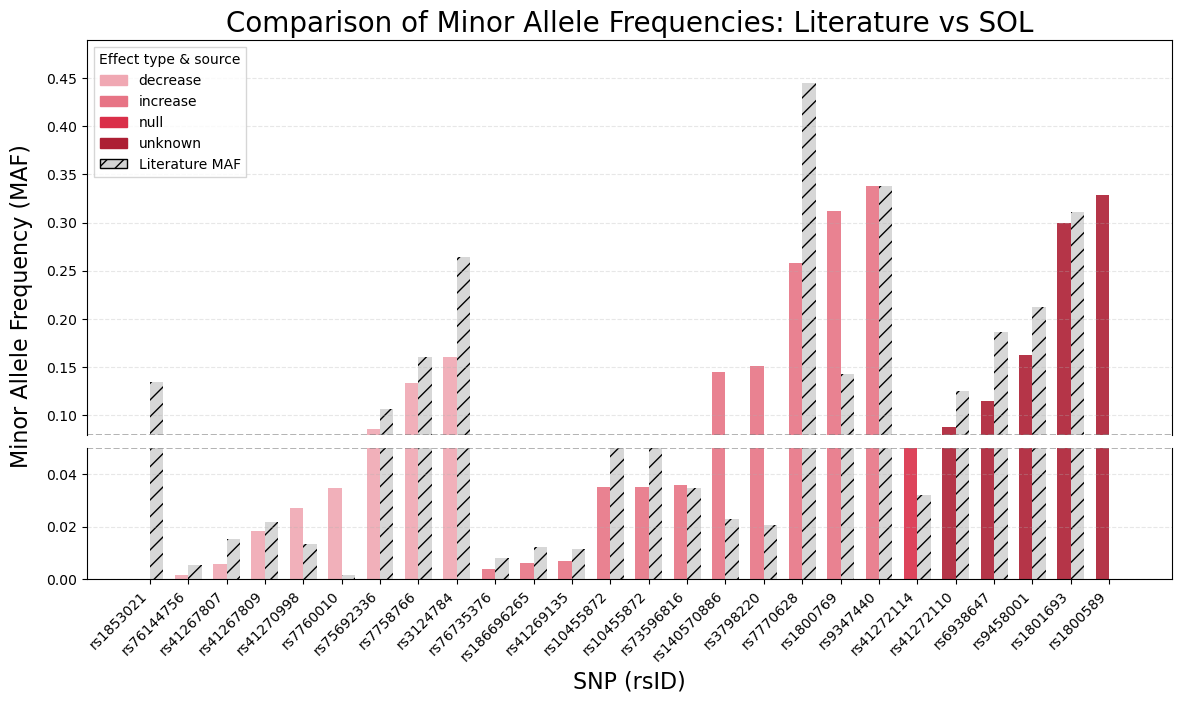

In [4]:
# ----------------------------
# Load your data
# ----------------------------

# Literature CSV
literature_file = "/nas/longleaf/home/catererz/epi/KIV-2_finemapping/LPA_finemapping_variants.csv"
lit_df = pd.read_csv(literature_file)

# SOL genotype summary TSV
sol_file = "/nas/longleaf/home/catererz/work/LPA_variant_carriers_plink/lpa_snps_genotypes_with_alleles_allele_summary.tsv"
sol_df = pd.read_csv(sol_file, sep="\t")

# ----------------------------
# Compute MAF for SOL
# ----------------------------

def compute_maf(row):
    # Extract allele counts
    counts = [row['A_carriers'], row['C_carriers'], row['G_carriers'], row['T_carriers']]
    counts = [c if pd.notna(c) else 0 for c in counts]  # Handle missing
    total_alleles = 2 * row['N_total']
    if total_alleles == 0:
        return None
    minor_count = min([c for c in counts if c > 0], default=0)
    maf = minor_count / total_alleles
    return maf

sol_df['SOL_MAF'] = sol_df.apply(compute_maf, axis=1)

# ----------------------------
# Merge with literature
# ----------------------------

# Clean literature positions
lit_df['POS'] = lit_df['hg38position'].str.split(":").str[1].astype(float)
lit_df['CHROM'] = lit_df['hg38position'].str.split(":").str[0]
lit_df["EFFECT"] = lit_df["effect"]

sol_df['CHROM'] = sol_df['CHROM'].str.replace("chr", "")

# Merge by chromosome + position
merged = pd.merge(
    lit_df,
    sol_df[['CHROM','POS','SOL_MAF']],
    on=['CHROM','POS'],
    how='left'
)

# Optional: clean literature MAF column to numeric (take ALFA if available)
def parse_lit_maf(maf_str):
    if pd.isna(maf_str):
        return None
    # Split on space, take first entry (ALFA)
    val = str(maf_str).split()[0].split("/")[0]
    try:
        return float(val)
    except:
        return None

merged['Literature_MAF'] = merged['maf'].apply(parse_lit_maf)
merged['effect'] = merged['effect'].fillna('null')

# ----------------------------
# Save merged table
# ----------------------------

merged.to_csv("results/maf_comparison.csv", index=False)
# print("Saved merged MAF table to results/maf_comparison.csv")


# Keep only SNPs that have both SOL and Literature MAF
plot_df = merged.dropna(subset=['SOL_MAF', 'Literature_MAF']).copy()
plot_df = plot_df.sort_values(['effect', 'POS'])  # Group by EFFECT first, then position
plot_df['effect'] = plot_df['effect'].replace({'unk': 'unknown'})

# Define effect order (controls group ordering on x-axis)
effect_order = ['decrease', 'increase', 'null', 'unknown']

# Sort داخل each group by SOL_MAF (small → large)
plot_df = (
    plot_df
    .assign(effect=pd.Categorical(plot_df['effect'], categories=effect_order, ordered=True))
    .sort_values(['effect', 'SOL_MAF'])
    .reset_index(drop=True)
)

effect_colors = { 
    'decrease': "#F0A8B3", 
    'increase': "#E77485", 
    # 'low': "#DA2F49", 
    # 'lead': "#64B5CD" 
    'null': "#DA2F49", 
    'unknown': "#AD1F34"
    }

# renmae unk to unknown

colors_lit = [effect_colors.get(e, 'lightgray') for e in plot_df['effect']]
colors_sol = [effect_colors.get(e, 'lightgray') for e in plot_df['effect']]

# ----------------------------
# Exclude specific SNPs (easy to extend)
# ----------------------------
exclude_rsids = ["rs139145675", "rs41267811","rs201306475","rs1623955","rs41267813", "rs41259144","rs143431368"]
plot_df = plot_df[~plot_df["rsID"].isin(exclude_rsids)].reset_index(drop=True)

# ----------------------------
# Recompute masks AFTER filtering
# ----------------------------
low_maf_mask = (plot_df['SOL_MAF'] < 0.05) & (plot_df['Literature_MAF'] < 0.05)
high_maf_mask = ~low_maf_mask

# X locations
x = np.arange(len(plot_df))
width = 0.35

# Effect colors per SNP
sol_colors = [effect_colors.get(e, 'lightgray') for e in plot_df['effect']]

# ----------------------------
# Create figure with split y-axis
# ----------------------------
fig, (ax_top, ax_bottom) = plt.subplots(
    2, 1, sharex=True, figsize=(14, 7),
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05}
)

# ----------------------------
# Bottom axis (zoomed low MAF)
# ----------------------------
ax_bottom.bar(x - width/2, plot_df['SOL_MAF'], width,
              color=sol_colors, alpha=0.9, label="SOL")

ax_bottom.bar(x + width/2, plot_df['Literature_MAF'], width,
              color='lightgray', alpha=0.9, label="Literature", 
              hatch='//')

# ----------------------------
# Top axis (full range)
# ----------------------------
ax_top.bar(x - width/2, plot_df['SOL_MAF'], width,
           color=sol_colors, alpha=0.9)

ax_top.bar(x + width/2, plot_df['Literature_MAF'], width,
           color='lightgray', alpha=0.9, hatch='//')

# ----------------------------
# Y limits (split)
# ----------------------------
ax_bottom.set_ylim(0, 0.05)
ax_top.set_ylim(0.08, plot_df[['SOL_MAF', 'Literature_MAF']].max().max() * 1.1)

# ----------------------------
# Break styling
# ----------------------------
ax_top.spines['bottom'].set_visible(False)
ax_bottom.spines['top'].set_visible(False)
ax_top.tick_params(labeltop=False)
ax_bottom.tick_params(top=False)
# Remove x tick marks from the split (top) panel
ax_top.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# ---------------------------- 
# # Add dashed break lines across the full plot width 
# # ---------------------------- 
# 
# bottom panel: top edge 
ax_bottom.axhline( 
    y=ax_bottom.get_ylim()[1], 
    linestyle="--", 
    linewidth=1.2, 
    color="gray", 
    alpha=0.7 
) 
# top panel: bottom edge 
ax_top.axhline( 
    y=ax_top.get_ylim()[0], 
    linestyle="--", 
    linewidth=1.2, 
    color="gray", 
    alpha=0.7 
)

# ----------------------------
# Labels
# ----------------------------
ax_bottom.set_xlabel("SNP (rsID)", fontsize=16)
fig.text(0.07, 0.5, "Minor Allele Frequency (MAF)", va='center', rotation='vertical', fontsize=16)

ax_bottom.set_xticks(x)
ax_bottom.set_xticklabels(plot_df['rsID'], rotation=45, ha='right')

# ----------------------------
# Grid
# ----------------------------
ax_top.grid(axis='y', alpha=0.3, linestyle='--')
ax_bottom.grid(axis='y', alpha=0.3, linestyle='--')

# ----------------------------
# Legend (effect groups)
# ----------------------------
effect_patches = [mpatches.Patch(color=c, label=lbl) for lbl, c in effect_colors.items()]

literature_patch = mpatches.Patch(
    facecolor='lightgray',
    hatch='//',
    edgecolor='black',
    label='Literature MAF'
)

ax_top.legend(
    handles=effect_patches + [literature_patch],
    title="Effect type & source",
    # bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=True,
    fancybox=False
)


# ----------------------------
# Title
# ----------------------------
ax_top.set_title("Comparison of Minor Allele Frequencies: Literature vs SOL", fontsize=20)

plt.tight_layout()
plt.savefig("results/maf_comparison_split_axis.png", dpi=300, bbox_inches='tight')
plt.show()


Merged PC shape: (12359, 28)
Columns: ['id', 'strat', 'psu_id', 'gold_id', 'gwas_id_x', 'subject_id_x', 'hh_id', 'source', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'goldid', 'sampleid', 'nwd_id_x', 'nwd_id_y', 'gengrp6', 'gwas_id_y', 'subject_id_y', 'bkgrd1', 'sex']


/tmp/ipykernel_1056279/2088444843.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(groups))


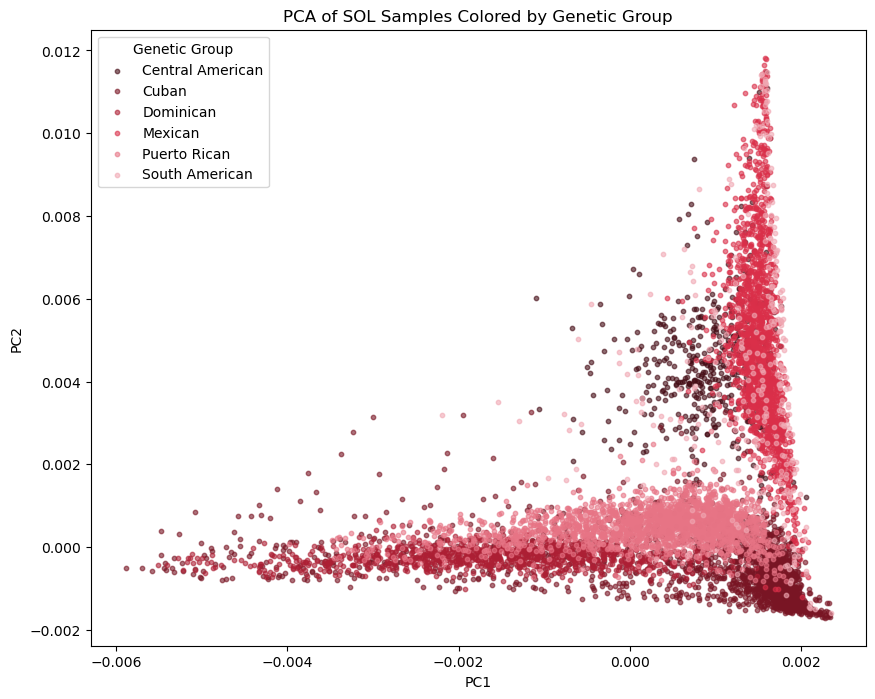

In [5]:
pc_data = pd.read_csv("/nas/longleaf/home/catererz/epi/GRiD/files/SOL_NWD_IDs_crosswalk.csv")
sol_gengrp6 = pd.read_csv("/proj/epi/CVDGeneNas/migraff/SOL/pheno/lpa/SOL_gengrp6.csv")

pc_data.columns = pc_data.columns.str.lower()
sol_gengrp6.columns = sol_gengrp6.columns.str.lower()

merged_pc = pd.merge(
    pc_data,
    sol_gengrp6,
    on='id',
    how='inner'
)

print("Merged PC shape:", merged_pc.shape)
print("Columns:", merged_pc.columns.tolist())

map_gen_groups = {
    'CentralAmerican': 'Central American', 
    'Cuban': 'Cuban', 
    'Dominican': 'Dominican', 
    'Mexican': 'Mexican', 
    'PuertoRican': 'Puerto Rican', 
    'SouthAmerican': 'South American'
}

effect_colors = { 
    'Central American': "#450C15",
    'Cuban': "#791524",
    'Dominican': "#AD1F34",
    'Mexican':  "#DA2F49", 
    'Puerto Rican': "#E77485", 
    'South American': "#F0A8B3"
    }  

merged_pc["gengrp6"] = merged_pc["gengrp6"].map(map_gen_groups)
# ----------------------------
# PCA Scatter Plot
# ----------------------------

plt.figure(figsize=(10, 8))
groups = sorted(merged_pc['gengrp6'].dropna().unique())
colors = plt.cm.get_cmap('tab10', len(groups))

for i, g in enumerate(groups):
    sub = merged_pc[merged_pc['gengrp6'] == g]
    plt.scatter(sub['pc1'], sub['pc2'], label=g, alpha=0.6, s=10, color=effect_colors[g])

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of SOL Samples Colored by Genetic Group')
plt.legend(title='Genetic Group')
plt.grid(False)
plt.savefig("results/sol_pca_by_genetic_group.png", dpi=300, bbox_inches='tight')
plt.show()

/nas/longleaf/home/catererz/.conda/envs/lpa/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


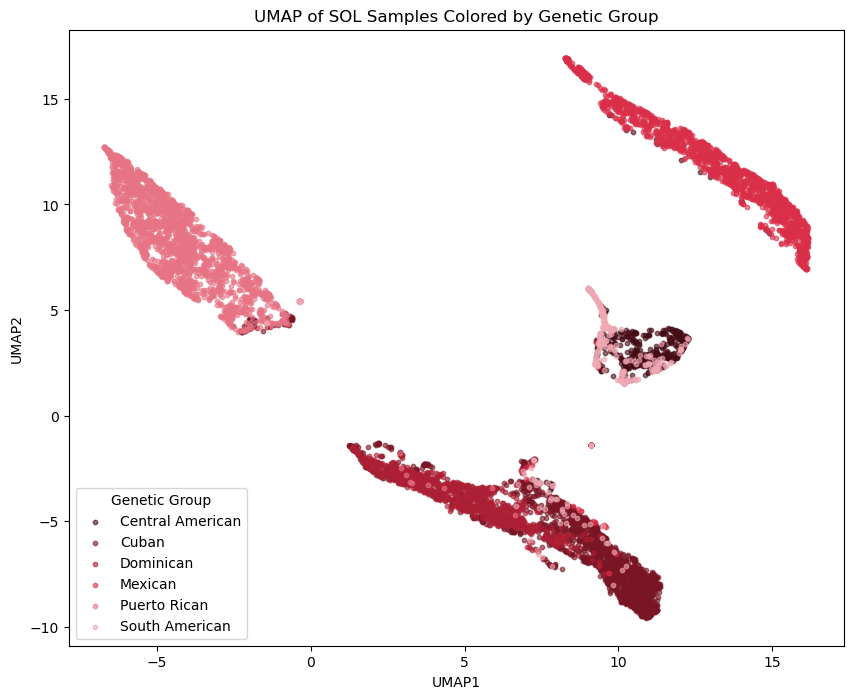

In [6]:
# Select PCs (use more than just PC1/PC2 — usually 10–50)
pc_cols = [c for c in merged_pc.columns if c.startswith("pc")]

# drop rows with missing PC values
merged_pc = merged_pc.dropna(subset=pc_cols)

X = merged_pc[pc_cols].values

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

umap_embedding = reducer.fit_transform(X)

# Add to dataframe
merged_pc["umap1"] = umap_embedding[:, 0]
merged_pc["umap2"] = umap_embedding[:, 1]

plt.figure(figsize=(10, 8))

groups = sorted(merged_pc['gengrp6'].dropna().unique())

for g in groups:
    sub = merged_pc[merged_pc['gengrp6'] == g]
    plt.scatter(sub['umap1'], sub['umap2'], label=g, alpha=0.6, s=10, color=effect_colors[g])

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP of SOL Samples Colored by Genetic Group")
plt.legend(title="Genetic Group")
plt.grid(False)
plt.savefig("results/sol_umap_by_genetic_group.png", dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_1056279/4046847315.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


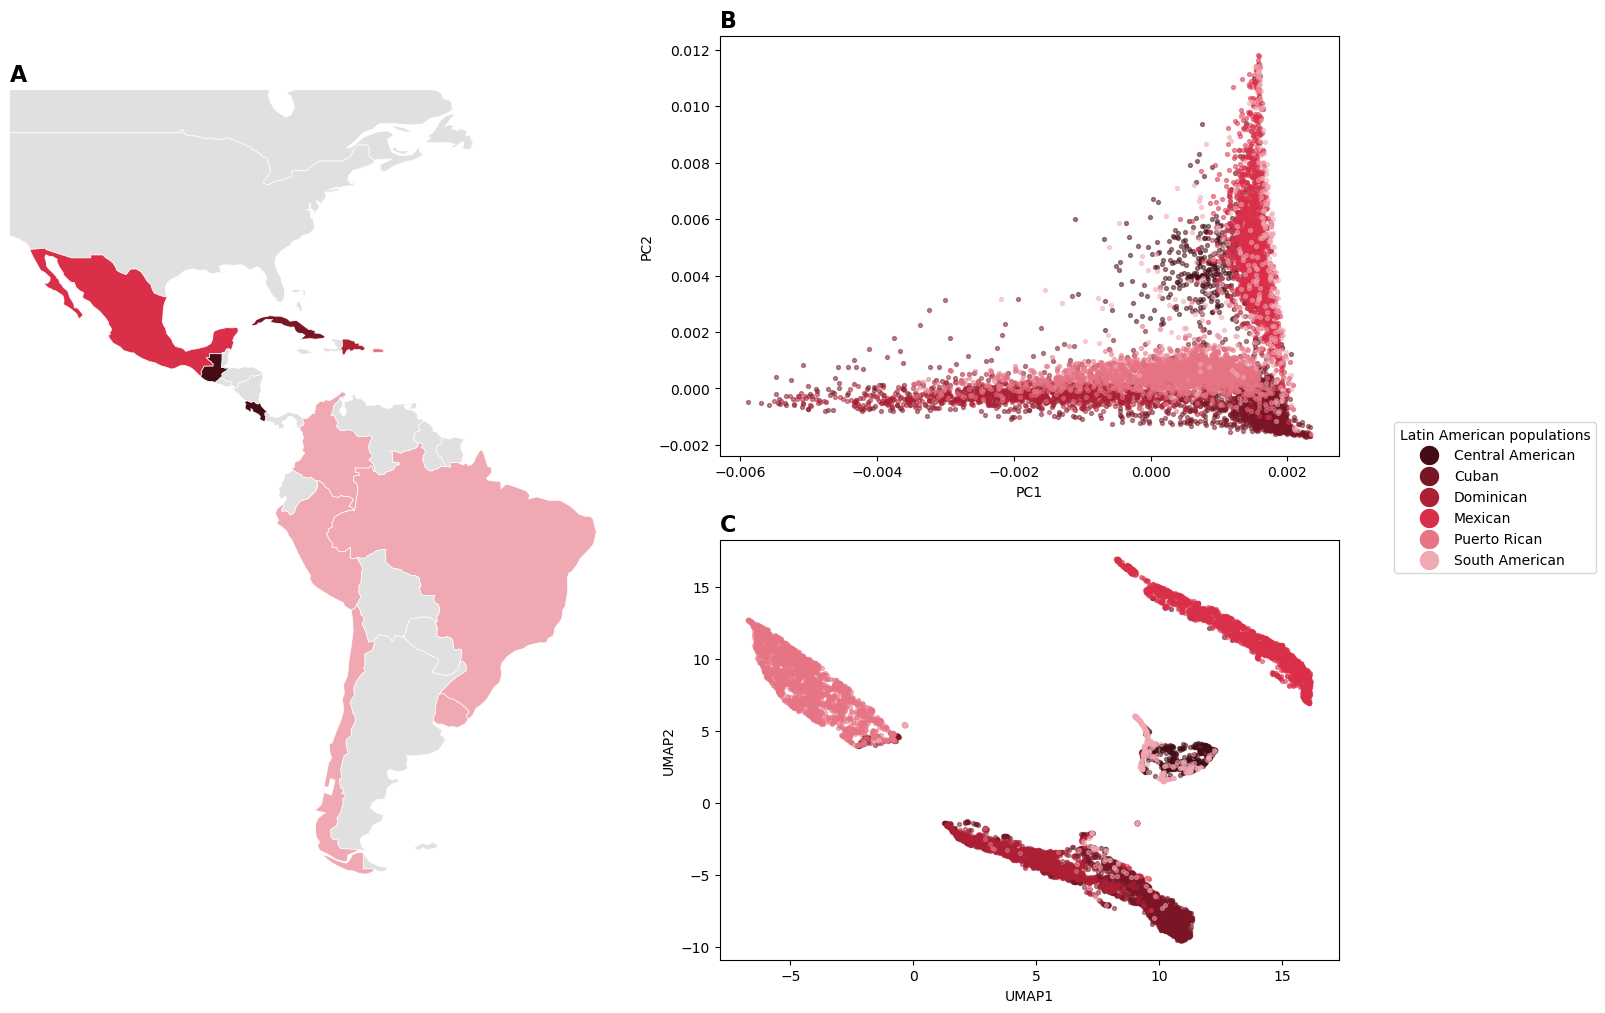

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import umap
import geopandas as gpd # Only if you want to generate the map
import geodatasets

# ---------------------------------------------------------
# PANEL A: The Map (Top Left and Bottom Left merged)
# ---------------------------------------------------------
# Mapping common country names to your gengrp6 labels
country_to_group = {
    'Mexico': 'Mexican',
    'Cuba': 'Cuban',
    'Dominican Rep.': 'Dominican',
    'Puerto Rico': 'Puerto Rican',
    # South American group
    'Brazil': 'South American', 'Colombia': 'South American', 'Peru': 'South American', 
    'Chile': 'South American', 'Argentina': 'South American', 'Uruguay': 'South American',
    'Ecuador': 'South American', 'Bolivia': 'South American',
    # Central American group
    'Guatemala': 'Central American', 'Honduras': 'Central American', 'El Salvador': 'Central American',
    'Nicaragua': 'Central American', 'Costa Rica': 'Central American', 'Panama': 'Central American'
}

# ---------------------------------------------------------
# PANEL A: The Map
# ---------------------------------------------------------

path = "/nas/longleaf/home/catererz/epi/GRiD/playground/cram_crai/results/geodata/ne_110m_admin_0_countries.shp"
world = gpd.read_file(path)

# 2. Define the Mapping (matching your effect_colors keys)
country_to_group = {
    'Mexico': 'Mexican',
    'Cuba': 'Cuban',
    'Dominican Rep.': 'Dominican',
    'Puerto Rico': 'Puerto Rican',
    'Brazil': 'South American', 'Colombia': 'South American', 'Peru': 'South American', 
    'Chile': 'South American', 'Uruguay': 'South American',
    'Guatemala': 'Central American', 'Costa Rica': 'Central American'
}
# print("World GeoDataFrame columns:", world.columns)
# print("World GeoDataFrame head:\n", world.head())
# 3. Filter for the Americas
# Note: 'name' or 'continent' column names might vary slightly by dataset version
# americas = world[world['continent'].isin(['North America', 'South America'])].copy()
# 3. Filter for the Americas
americas = world[world['CONTINENT'].isin(['North America', 'South America'])].copy()

# 4. Map the colors
def get_color(row):
    name = row['NAME']  # Use uppercase
    group = country_to_group.get(name)
    return effect_colors.get(group, '#E0E0E0')  # Light gray for non-target countries

americas['plot_color'] = americas.apply(get_color, axis=1)

fig = plt.figure(figsize=(20, 12))  # Make width bigger for legend
gs = gridspec.GridSpec(2, 3, width_ratios=[2, 2, 0.42], height_ratios=[1, 1], wspace=0.2, hspace=0.2)

# ---------------------------------------------------------
# PANEL A: Map (Column 1, spans both rows)
# ---------------------------------------------------------
ax_map = fig.add_subplot(gs[:, 0])
ax_map.set_title("A", loc='left', fontsize=16, fontweight='bold')

americas.plot(
    ax=ax_map,
    color=americas['plot_color'],
    edgecolor='white',
    linewidth=0.5
)

ax_map.set_xlim([-120, -30])
ax_map.set_ylim([-60, 55])
ax_map.axis('off')

# ---------------------------------------------------------
# PANEL B: PCA (Top Right, Column 2)
# ---------------------------------------------------------
ax_pca = fig.add_subplot(gs[0, 1])
ax_pca.set_title("B", loc='left', fontsize=16, fontweight='bold')

for g in groups:
    sub = merged_pc[merged_pc['gengrp6'] == g]
    ax_pca.scatter(
        sub['pc1'], sub['pc2'],
        label=g, alpha=0.5, s=8,
        color=effect_colors[g],
        marker='o'
    )

ax_pca.set_xlabel('PC1')
ax_pca.set_ylabel('PC2')
ax_pca.grid(False)
# ax_pca.set_aspect('equal')  # square

# ---------------------------------------------------------
# PANEL C: UMAP (Bottom Right, Column 2)
# ---------------------------------------------------------
ax_umap = fig.add_subplot(gs[1, 1])
ax_umap.set_title("C", loc='left', fontsize=16, fontweight='bold')

for g in groups:
    sub = merged_pc[merged_pc['gengrp6'] == g]
    ax_umap.scatter(
        sub['umap1'], sub['umap2'],
        label=g, alpha=0.5, s=8,
        color=effect_colors[g]
    )

ax_umap.set_xlabel("UMAP1")
ax_umap.set_ylabel("UMAP2")
ax_umap.grid(False)
# ax_umap.set_aspect('equal')  # square

# ---------------------------------------------------------
# LEGEND (Column 3)
# ---------------------------------------------------------
ax_legend = fig.add_subplot(gs[:, 2])  # span both rows
ax_legend.axis('off')  # no axes

# Create a legend manually
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=effect_colors[g], markersize=15, label=g) 
           for g in groups]
ax_legend.legend(handles=handles, title='Latin American populations', loc='center')

plt.tight_layout()
plt.savefig("results/combined_genetic_structure.png", dpi=300, bbox_inches='tight')
plt.show()


Total nodes: 4963
Total edges: 4460012
Largest CC nodes: 4151
Largest CC edges: 4459681
Detected 3 clusters


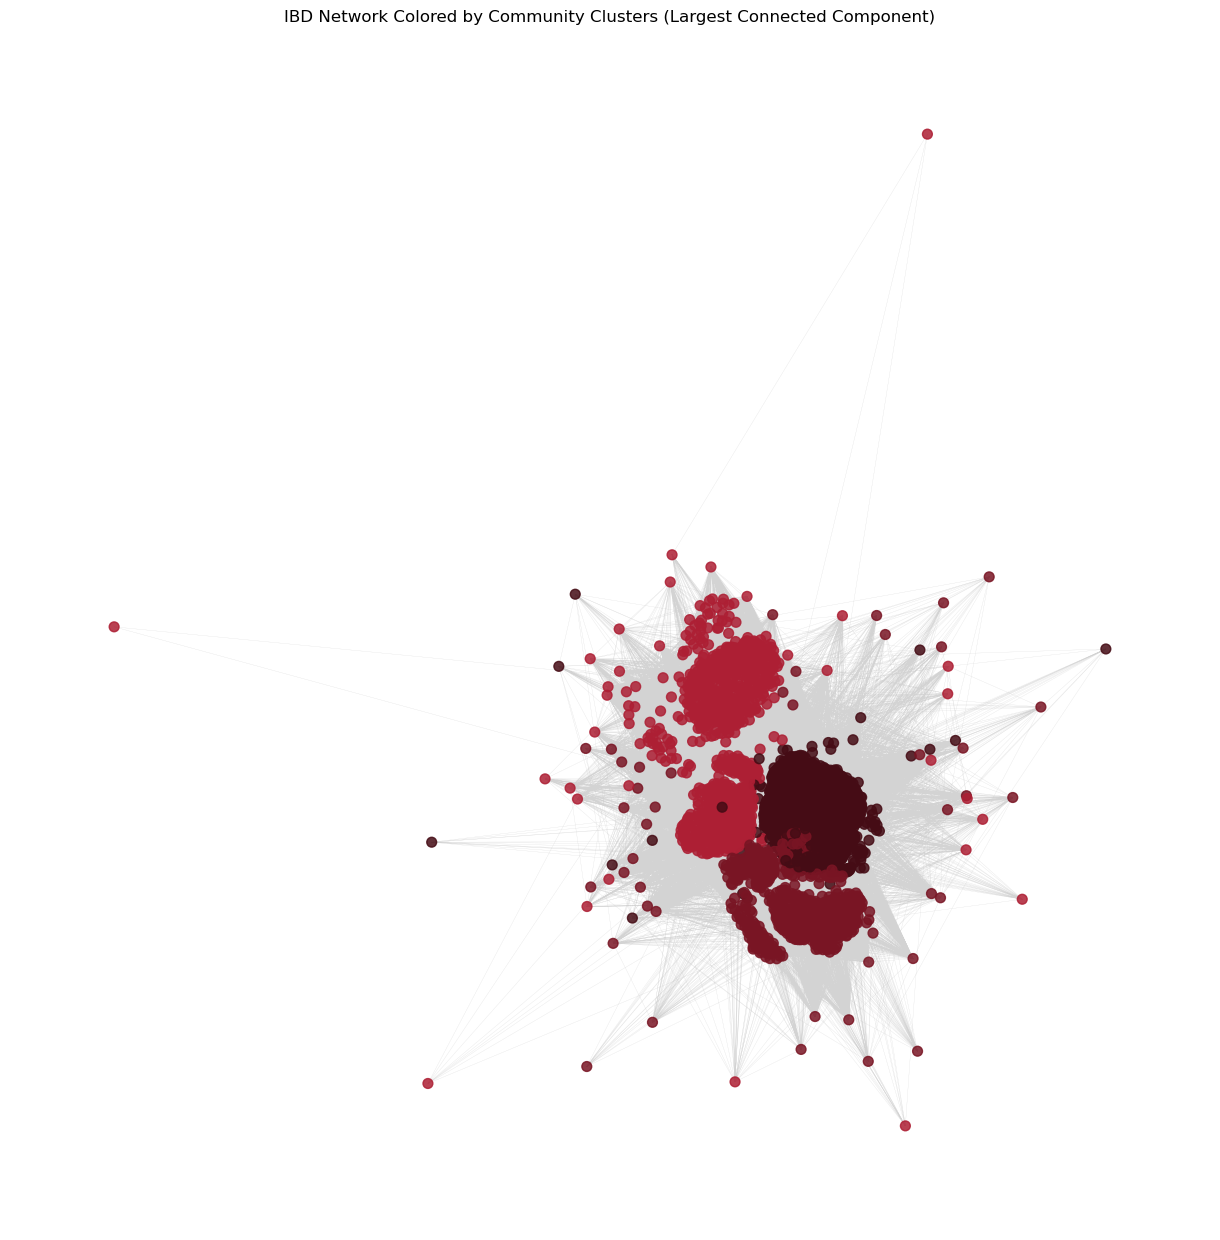

In [22]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
import community as community_louvain

# ---------------------------
# Load IBD match file
# ---------------------------
file_path = "/nas/longleaf/home/catererz/work/ibd/output_chr6.match"

cols = [
    "ID1", "ID1_chr", "ID2", "ID2_chr", "chrom", "start", "end",
    "start_snp", "end_snp", "length", "count"
]

df = pd.read_csv(file_path, sep="\t", header=None, names=cols)

# ---------------------------
# Define color palette (reuse your ancestry colors)
# ---------------------------
effect_colors = { 
    'Central American': "#450C15",
    'Cuban': "#791524",
    'Dominican': "#AD1F34",
    'Mexican':  "#DA2F49", 
    'Puerto Rican': "#E77485", 
    'South American': "#F0A8B3",
    "Other": "#929292"
}

cluster_palette = list(effect_colors.values())

# ---------------------------
# Build IBD graph
# ---------------------------
G = nx.Graph()

for _, row in df.iterrows():
    G.add_edge(row['ID1'], row['ID2'])

# Remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))

print("Total nodes:", G.number_of_nodes())
print("Total edges:", G.number_of_edges())

# ---------------------------
# Extract largest connected component
# ---------------------------
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

print("Largest CC nodes:", G.number_of_nodes())
print("Largest CC edges:", G.number_of_edges())

# ---------------------------
# Community detection (clusters)
# ---------------------------
communities = list(greedy_modularity_communities(G))
partition = community_louvain.best_partition(G, resolution=1.5)  # try 1.2–2.0 for more clusters

print(f"Detected {len(communities)} clusters")

# Assign cluster id to each node
node_cluster = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_cluster[node] = i

# Assign colors by cluster
node_colors = []
for node in G.nodes():
    cluster_id = node_cluster[node]
    color = cluster_palette[cluster_id % len(cluster_palette)]
    node_colors.append(color)

# Optional: scale node size by degree
# node_sizes = [G.degree(n) * 1.5 for n in G.nodes()]

# ---------------------------
# Plot network
# ---------------------------
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, seed=42, k=0.15)

nx.draw(
    G,
    pos,
    node_color=node_colors,
    node_size=50,
    alpha=0.85,
    edge_color='lightgray',
    width=0.15,
    with_labels=False
)

# Draw edges (light gray, transparent)
nx.draw_networkx_edges(
    G,
    pos,
    edge_color="lightgray",
    alpha=0.15,
    width=0.1
    # with_labels=False
)

# plt.title("IBD Network Colored by Community Clusters (Largest Connected Component)")
plt.axis("off")

# Save if desired
# plt.savefig("ibd_network_clusters_chr6.png", dpi=300, bbox_inches="tight")

plt.show()


# Old

In [ ]:
import argparse
import seaborn as sns
from scipy import stats
from pathlib import Path
import sys

from src.plot_lpa_ass import *
from src.plot_vntr_lpa_dipCN_ass import *


# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


def load_kiv2_estimates(estimate_file):
    """
    Load KIV2 copy number estimates.
    
    Expected columns: ID, exon1A, exon1B, dip_estimate, estimate
    """
    print(f"Loading KIV2 estimates from {estimate_file}...")
    try:
        df = pd.read_csv(estimate_file, sep='\t')
        
        # Check if 'ID' column exists, if so, set it as index
        if 'ID' in df.columns:
            df.set_index('ID', inplace=True)
        
        print(f"  Loaded {len(df)} samples")
        print(f"  Columns: {list(df.columns)}")
        return df
    except Exception as e:
        print(f"ERROR: Failed to load KIV2 estimates: {e}", file=sys.stderr)
        sys.exit(1)


def load_lpa_data(lpa_file):
    """
    Load Lp(a) measurements.
    
    Expected columns: id, subject_id, nwd_id, gwas_id, bkgrd1, lpa_nmol
    """
    print(f"\nLoading Lp(a) data from {lpa_file}...")
    try:
        df = pd.read_csv(lpa_file)
        df.columns = [col.lower() for col in df.columns]
        print(f"  Loaded {len(df)} samples")
        
        # Remove quotes from NWD_ID if present
        if 'nwd_id' in df.columns:
            df['nwd_id'] = df['nwd_id'].astype(str).str.strip('"').str.strip()
        
        # Filter out missing NWD IDs and Lp(a) values
        original_len = len(df)
        df = df[df['nwd_id'].notna() & (df['nwd_id'] != 'NA') & (df['nwd_id'] != 'nan')]
        df = df[df['lpa_nmol'].notna()]
        
        print(f"  After filtering: {len(df)} samples with valid NWD ID and Lp(a)")
        print(f"  Removed {original_len - len(df)} samples with missing data")
        
        # Convert lpa_nmol to numeric (in case there are string issues)
        df['lpa_nmol'] = pd.to_numeric(df['lpa_nmol'], errors='coerce')
        df = df[df['lpa_nmol'].notna()]
        
        print(f"  First few nwd_ids: {list(df['nwd_id'].head())}")
        
        return df
    except Exception as e:
        print(f"ERROR: Failed to load Lp(a) data: {e}", file=sys.stderr)
        sys.exit(1)


def merge_data(kiv2_df, lpa_df):
    """
    Merge KIV2 estimates with Lp(a) data on NWD ID.
    """
    print("\nMerging KIV2 estimates with Lp(a) data...")
    
    # KIV2 estimates have NWD ID as index, reset it to a column
    kiv2_df_reset = kiv2_df.reset_index()
    
    # Rename the ID column to nwd_id for consistency
    if 'ID' in kiv2_df_reset.columns:
        kiv2_df_reset.rename(columns={'ID': 'nwd_id'}, inplace=True)
    elif 'index' in kiv2_df_reset.columns:
        kiv2_df_reset.rename(columns={'index': 'nwd_id'}, inplace=True)
    else:
        # First column is the ID column
        kiv2_df_reset.rename(columns={kiv2_df_reset.columns[0]: 'nwd_id'}, inplace=True)
    
    # Strip whitespace from nwd_id in both dataframes
    kiv2_df_reset['nwd_id'] = kiv2_df_reset['nwd_id'].astype(str).str.strip()
    lpa_df['nwd_id'] = lpa_df['nwd_id'].astype(str).str.strip()
    
    print(f"  KIV2 columns: {list(kiv2_df_reset.columns)}")
    print(f"  First few KIV2 IDs: {list(kiv2_df_reset['nwd_id'].head())}")
    print(f"  First few Lp(a) IDs: {list(lpa_df['nwd_id'].head())}")
    
    # Merge on nwd_id
    merged = pd.merge(
        kiv2_df_reset,
        lpa_df[['nwd_id', 'lpa_nmol', 'bkgrd1']],
        on='nwd_id',
        how='inner'
    )
    
    print(f"  Merged dataset: {len(merged)} samples")
    print(f"  Samples in KIV2 only: {len(kiv2_df) - len(merged)}")
    print(f"  Samples in Lp(a) only: {len(lpa_df) - len(merged)}")
    
    if len(merged) == 0:
        print("ERROR: No overlapping samples found!", file=sys.stderr)
        print("\nDebugging - checking for case sensitivity or format differences...")
        kiv2_ids = set(kiv2_df_reset['nwd_id'].str.upper())
        lpa_ids = set(lpa_df['nwd_id'].str.upper())
        overlap = kiv2_ids & lpa_ids
        print(f"  Case-insensitive overlap: {len(overlap)} samples")
        if len(overlap) > 0:
            print("  Issue: Sample IDs have different cases!")
        sys.exit(1)
    
    return merged


def compute_statistics(merged_df):
    """
    Compute correlation and regression statistics.
    """
    print("\nComputing statistics...")
    
    # Remove any remaining NaN values
    clean_df = merged_df[['estimate', 'lpa_nmol']].dropna()
    
    # Pearson correlation
    pearson_r, pearson_p = stats.pearsonr(clean_df['estimate'], clean_df['lpa_nmol'])
    
    # Spearman correlation (non-parametric)
    spearman_r, spearman_p = stats.spearmanr(clean_df['estimate'], clean_df['lpa_nmol'])
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        clean_df['estimate'], clean_df['lpa_nmol']
    )
    
    print(f"  N = {len(clean_df)}")
    print(f"  Pearson correlation: r = {pearson_r:.3f}, p = {pearson_p:.2e}")
    print(f"  Spearman correlation: ρ = {spearman_r:.3f}, p = {spearman_p:.2e}")
    print(f"  Linear regression: slope = {slope:.3f}, R² = {r_value**2:.3f}")
    
    return {
        'n': len(clean_df),
        'pearson_r': pearson_r,
        'pearson_p': pearson_p,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p,
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2,
        'reg_p': p_value
    }


def create_plots(merged_df, stats_dict, output_prefix):
    """
    Create visualization plots.
    """
    print("\nCreating plots...")
    
    # Remove NaN values for plotting
    plot_df = merged_df[['estimate', 'lpa_nmol', 'bkgrd1']].dropna()
    
    # Figure 1: Scatter plot with regression line
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Scatter plot
    ax.scatter(plot_df['estimate'], plot_df['lpa_nmol'], 
               alpha=0.5, s=15, edgecolors='black', linewidth=0.5)
    
    # Add regression line
    x_range = np.linspace(plot_df['estimate'].min(), plot_df['estimate'].max(), 100)
    y_pred = stats_dict['slope'] * x_range + stats_dict['intercept']
    # ax.plot(x_range, y_pred, 'r-', linewidth=2, label='Linear regression')
    
    # Labels and title
    ax.set_xlabel('KIV2 Copy Number (haploid estimate)', fontsize=14)
    ax.set_ylabel('Lp(a) [nmol/L]', fontsize=14)
    ax.set_title('KIV2 Copy Number and Lp(a) Levels', 
                 fontsize=16, fontweight='bold')
    
    # Add statistics text
    stats_text = (f"N = {stats_dict['n']}\n"
                  f"Pearson r = {stats_dict['pearson_r']:.3f}\n"
                  f"p = {stats_dict['pearson_p']:.2e}\n"
                  f"R² = {stats_dict['r_squared']:.3f}")
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Save figure 1
    plot1_path = f"{output_prefix}_scatter.png"
    plt.tight_layout()
    plt.savefig(plot1_path, dpi=300, bbox_inches='tight')
    print(f"  Saved: {plot1_path}")
    plt.close()
    
    # Figure 2: Log-scale Lp(a)
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Log transform Lp(a) (add small constant to handle zeros)
    plot_df['log_lpa'] = np.log10(plot_df['lpa_nmol'] + 0.1)
    
    ax.scatter(plot_df['estimate'], plot_df['log_lpa'], 
               alpha=0.5, s=50, edgecolors='black', linewidth=0.5)
    
    # Regression on log scale
    slope_log, intercept_log, r_log, p_log, _ = stats.linregress(
        plot_df['estimate'], plot_df['log_lpa']
    )
    x_range = np.linspace(plot_df['estimate'].min(), plot_df['estimate'].max(), 100)
    y_pred_log = slope_log * x_range + intercept_log
    ax.plot(x_range, y_pred_log, 'r-', linewidth=2, label='Linear regression')
    
    ax.set_xlabel('KIV2 Copy Number (haploid estimate)', fontsize=14)
    ax.set_ylabel('log₁₀(Lp(a) [nmol/L])', fontsize=14)
    ax.set_title('KIV2 Copy Number vs log-transformed Lp(a)', 
                 fontsize=16, fontweight='bold')
    
    stats_text_log = (f"N = {len(plot_df)}\n"
                      f"R² = {r_log**2:.3f}\n"
                      f"p = {p_log:.2e}")
    ax.text(0.05, 0.95, stats_text_log, transform=ax.transAxes,
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plot2_path = f"{output_prefix}_scatter_log.png"
    plt.tight_layout()
    plt.savefig(plot2_path, dpi=300, bbox_inches='tight')
    print(f"  Saved: {plot2_path}")
    plt.close()
    
    # Figure 3: Distribution plots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # KIV2 distribution
    axes[0, 0].hist(plot_df['estimate'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('KIV2 Copy Number')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Distribution of KIV2 Copy Numbers')
    # axes[0, 0].axvline(plot_df['estimate'].median(), color='r', 
    #                    linestyle='--', label=f'Median: {plot_df["estimate"].median():.2f}')
    axes[0, 0].legend()
    
    # Lp(a) distribution
    axes[0, 1].hist(plot_df['lpa_nmol'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Lp(a) [nmol/L]')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Distribution of Lp(a) Levels')
    # axes[0, 1].axvline(plot_df['lpa_nmol'].median(), color='r',
    #                    linestyle='--', label=f'Median: {plot_df["lpa_nmol"].median():.2f}')
    axes[0, 1].legend()
    
    # Box plot by KIV2 bins
    plot_df['kiv2_bin'] = pd.cut(plot_df['estimate'], bins=5)
    axes[1, 0].boxplot([group['lpa_nmol'].values for name, group in plot_df.groupby('kiv2_bin', observed=True)],
                       labels=[f"{interval.left:.1f}-{interval.right:.1f}" 
                              for interval in plot_df.groupby('kiv2_bin', observed=True).groups.keys()])
    axes[1, 0].set_xlabel('KIV2 Copy Number Bins')
    axes[1, 0].set_ylabel('Lp(a) [nmol/L]')
    axes[1, 0].set_title('Lp(a) Distribution by KIV2 Bins')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Residual plot
    # y_pred_full = stats_dict['slope'] * plot_df['estimate'] + stats_dict['intercept']
    # residuals = plot_df['lpa_nmol'] - y_pred_full
    # axes[1, 1].scatter(plot_df['estimate'], residuals, alpha=0.5)
    # axes[1, 1].axhline(0, color='r', linestyle='--')
    # axes[1, 1].set_xlabel('KIV2 Copy Number')
    # axes[1, 1].set_ylabel('Residuals')
    # axes[1, 1].set_title('Residual Plot')
    # axes[1, 1].grid(True, alpha=0.3)

    # Figure 2b: Log-scale association plot (replace residuals)
    ax = axes[1, 1]  # existing subplot

    # Log transform Lp(a) (add small constant to handle zeros)
    plot_df['log_lpa'] = np.log10(plot_df['lpa_nmol'] + 0.1)

    # Scatter plot
    ax.scatter(plot_df['estimate'], plot_df['log_lpa'], 
            alpha=0.5, s=50, edgecolors='black', linewidth=0.5, label='Data')

    # Linear regression on log scale
    slope_log, intercept_log, r_log, p_log, _ = stats.linregress(
        plot_df['estimate'], plot_df['log_lpa']
    )
    x_range = np.linspace(plot_df['estimate'].min(), plot_df['estimate'].max(), 100)
    y_pred_log = slope_log * x_range + intercept_log
    ax.plot(x_range, y_pred_log, 'r-', linewidth=2, label='Linear regression')

    # Labels and title
    ax.set_xlabel('KIV2 Copy Number (haploid estimate)', fontsize=12)
    ax.set_ylabel('log₁₀(Lp(a) [nmol/L])', fontsize=12)
    ax.set_title('KIV2 Copy Number vs log-transformed Lp(a)', fontsize=14)

    # Stats box
    stats_text_log = (f"N = {len(plot_df)}\n"
                    f"R² = {r_log**2:.3f}\n"
                    f"p = {p_log:.2e}")
    ax.text(0.05, 0.05, stats_text_log, transform=ax.transAxes,
            fontsize=10, verticalalignment='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # ax.legend()
    ax.grid(True, alpha=0.3)

    
    plot3_path = f"{output_prefix}_distributions.png"
    plt.tight_layout()
    plt.savefig(plot3_path, dpi=300, bbox_inches='tight')
    print(f"  Saved: {plot3_path}")
    plt.close()


def save_merged_data(merged_df, output_file):
    """
    Save merged dataset for downstream analysis.
    """
    print(f"\nSaving merged dataset to {output_file}...")
    merged_df.to_csv(output_file, sep='\t', index=False)
    print(f"  Saved {len(merged_df)} samples")


In [5]:
# Load data
kiv2_df = load_kiv2_estimates("/nas/longleaf/home/catererz/work/updated_LPA_VNTR_SOFTWARE/lpa_kiv2_cn.txt")
lpa_df = load_lpa_data("/nas/longleaf/home/catererz/epi/GRiD/files/merged_diploid_calls.csv")

# Merge datasets
merged_df = merge_data(kiv2_df, lpa_df)

# Compute statistics
stats_dict = compute_statistics(merged_df)

# Create plots
create_plots(merged_df, stats_dict, "results/")

# Save merged data
save_merged_data(merged_df, "results/kiv2_lpa_merged.txt")

Loading KIV2 estimates from /nas/longleaf/home/catererz/work/updated_LPA_VNTR_SOFTWARE/lpa_kiv2_cn.txt...
  Loaded 7041 samples
  Columns: ['exon1A', 'exon1B', 'dip_estimate', 'estimate']

Loading Lp(a) data from /nas/longleaf/home/catererz/epi/GRiD/files/merged_diploid_calls.csv...
  Loaded 16415 samples
  After filtering: 13747 samples with valid NWD ID and Lp(a)
  Removed 2668 samples with missing data
  First few nwd_ids: ['NWD725683', 'NWD565678', 'NWD863074', 'NWD161576', 'NWD573378']

Merging KIV2 estimates with Lp(a) data...
  KIV2 columns: ['nwd_id', 'exon1A', 'exon1B', 'dip_estimate', 'estimate']
  First few KIV2 IDs: ['NWD100014', 'NWD100472', 'NWD100481', 'NWD100539', 'NWD100597']
  First few Lp(a) IDs: ['NWD725683', 'NWD565678', 'NWD863074', 'NWD161576', 'NWD573378']
  Merged dataset: 3687 samples
  Samples in KIV2 only: 3354
  Samples in Lp(a) only: 10060

Computing statistics...
  N = 3687
  Pearson correlation: r = -0.503, p = 1.22e-235
  Spearman correlation: ρ = -0.53

/tmp/ipykernel_1913340/634760611.py:191: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


  Saved: results/_scatter.png
  Saved: results/_scatter_log.png


/tmp/ipykernel_1913340/634760611.py:249: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 0].legend()
/tmp/ipykernel_1913340/634760611.py:258: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()
/tmp/ipykernel_1913340/634760611.py:262: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([group['lpa_nmol'].values for name, group in plot_df.groupby('kiv2_bin', observed=True)],


  Saved: results/_distributions.png

Saving merged dataset to results/kiv2_lpa_merged.txt...
  Saved 3687 samples


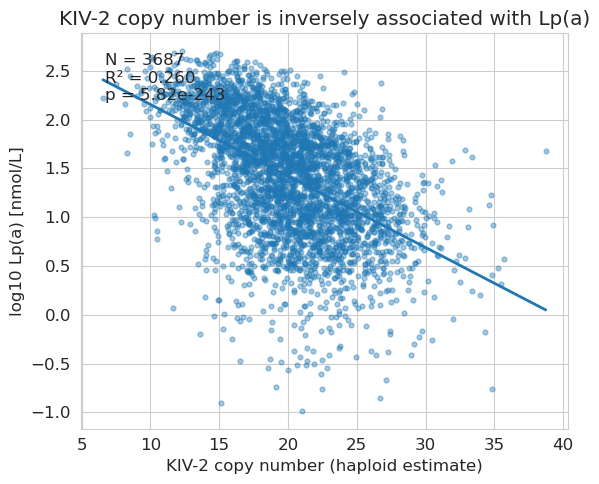

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("/nas/longleaf/home/catererz/work/updated_LPA_VNTR_SOFTWARE/kiv2_lpa_merged.txt", sep="\t")


df = df[['estimate', 'lpa_nmol']].dropna()
df['log_lpa'] = np.log10(df['lpa_nmol'] + 0.1)

# regression
slope, intercept, r, p, _ = stats.linregress(df['estimate'], df['log_lpa'])

plt.figure(figsize=(6,5))
plt.scatter(df['estimate'], df['log_lpa'], alpha=0.4, s=12)

x = np.linspace(df['estimate'].min(), df['estimate'].max(), 200)
y = slope * x + intercept
plt.plot(x, y, linewidth=2)

plt.xlabel("KIV-2 copy number (haploid estimate)")
plt.ylabel("log10 Lp(a) [nmol/L]")
plt.title("KIV-2 copy number is inversely associated with Lp(a)")

plt.text(
    0.05, 0.95,
    f"N = {len(df)}\nR² = {r**2:.3f}\np = {p:.2e}",
    transform=plt.gca().transAxes,
    verticalalignment="top"
)

plt.tight_layout()
plt.savefig("results/Figure1_KIV2_vs_LPA.png", dpi=300)
plt.show()
plt.close()

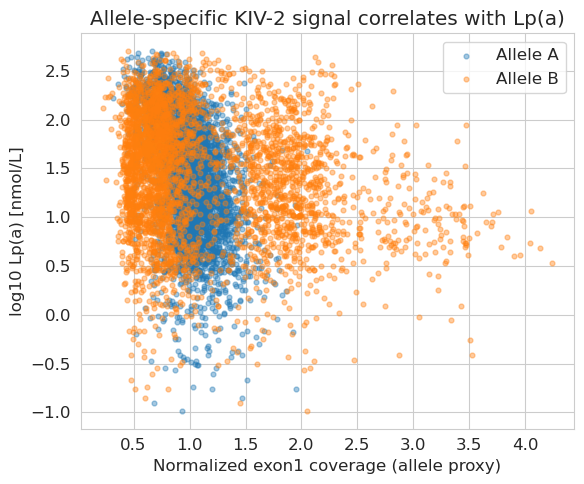

In [5]:
df = pd.read_csv("/nas/longleaf/home/catererz/work/updated_LPA_VNTR_SOFTWARE/kiv2_lpa_merged.txt", sep="\t")

df = df[['exon1A', 'exon1B', 'lpa_nmol']].dropna()
df['log_lpa'] = np.log10(df['lpa_nmol'] + 0.1)

plt.figure(figsize=(6,5))

plt.scatter(df['exon1A'], df['log_lpa'], alpha=0.4, s=12, label="Allele A")
plt.scatter(df['exon1B'], df['log_lpa'], alpha=0.4, s=12, label="Allele B")

plt.xlabel("Normalized exon1 coverage (allele proxy)")
plt.ylabel("log10 Lp(a) [nmol/L]")
plt.title("Allele-specific KIV-2 signal correlates with Lp(a)")
plt.legend()

plt.tight_layout()
plt.savefig("results/Figure2_Allelic_signal_vs_LPA.png", dpi=300)
plt.show()
plt.close()


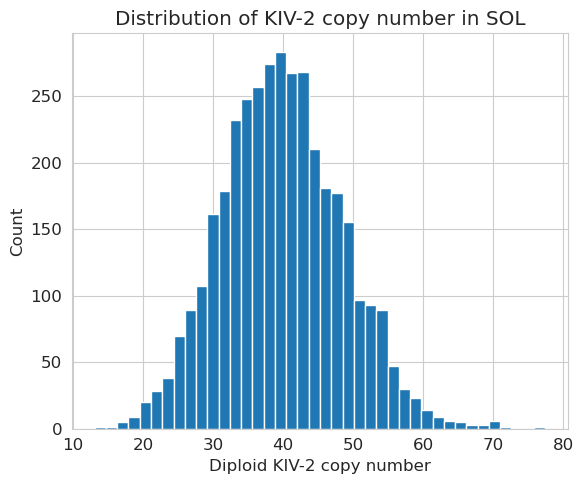

In [6]:
df = pd.read_csv("/nas/longleaf/home/catererz/work/updated_LPA_VNTR_SOFTWARE/kiv2_lpa_merged.txt", sep="\t")

plt.figure(figsize=(6,5))
plt.hist(df['dip_estimate'], bins=40)
plt.xlabel("Diploid KIV-2 copy number")
plt.ylabel("Count")
plt.title("Distribution of KIV-2 copy number in SOL")
plt.tight_layout()
plt.savefig("results/Figure3_KIV2_distribution.png", dpi=300)
plt.show()
plt.close()

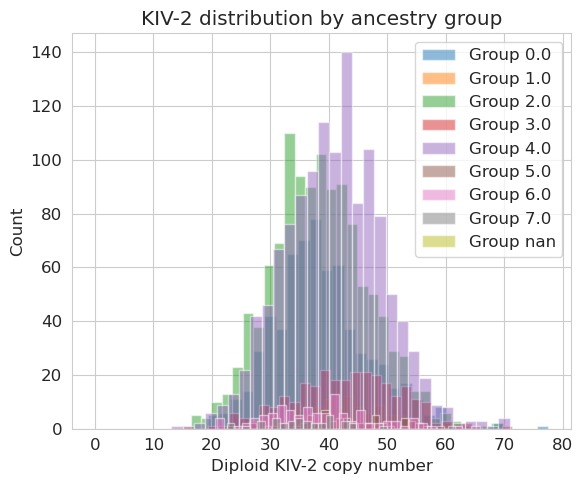

In [7]:
plt.figure(figsize=(6,5))

for anc in sorted(df['bkgrd1'].unique()):
    sub = df[df['bkgrd1'] == anc]
    plt.hist(sub['dip_estimate'], bins=30, alpha=0.5, label=f"Group {anc}")

plt.xlabel("Diploid KIV-2 copy number")
plt.ylabel("Count")
plt.title("KIV-2 distribution by ancestry group")
plt.legend()
plt.tight_layout()
plt.savefig("results/Figure4_KIV2_by_ancestry.png", dpi=300)
plt.show()
plt.close()


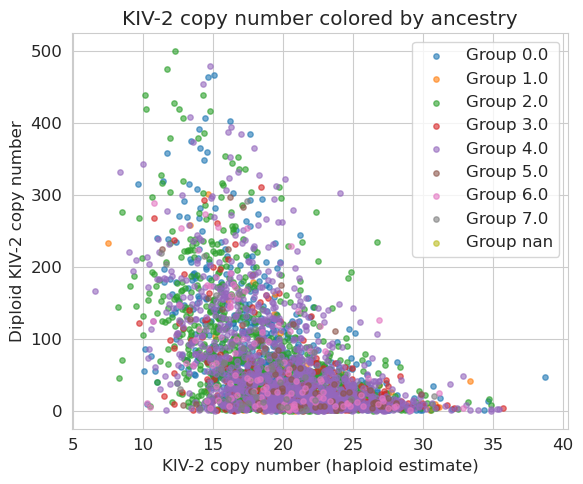

In [8]:
plt.figure(figsize=(6,5))

for anc in sorted(df['bkgrd1'].unique()):
    sub = df[df['bkgrd1'] == anc]
    plt.scatter(
        sub["estimate"],
        sub["lpa_nmol"],
        alpha=0.6,
        s=15,
        label=f"Group {anc}"
    )

plt.xlabel("KIV-2 copy number (haploid estimate)")
plt.ylabel("Diploid KIV-2 copy number")
plt.title("KIV-2 copy number colored by ancestry")
plt.legend()
plt.tight_layout()
plt.savefig("results/Figure4_KIV2_by_ancestry.png", dpi=300)
plt.show()
plt.close()
